# Traffic sign detection and classification

In [154]:
from xml.dom import minidom
from os import walk
import pandas as pd
import cv2 as cv
import numpy as np
from sklearn import metrics
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
filenames = next(walk("res/annotations"), (None, None, []))[2]  # [] if no file

signs = []

for annotation in filenames:
    file = minidom.parse("res/annotations/" + annotation)
    if len(file.getElementsByTagName('name')) == 1:
        path = "res/images/" + file.getElementsByTagName('filename')[0].firstChild.data
        filename = file.getElementsByTagName('filename')[0].firstChild.data
        name = file.getElementsByTagName('name')[0].firstChild.data

        if name == "trafficlight":
            continue

        signs.append([filename, name, path])

df = pd.DataFrame(signs, columns=['filename', 'name', 'path'])


In [156]:
def condition_classes(s):
    if s['name'] == 'speedlimit':
        return 0
    elif s["name"] == 'crosswalk':
        return 1
    elif s["name"] == "stop":
        return 2


df["class"] = df.apply(condition_classes, axis=1)

In [157]:
def concatenate_and_write(row):
    img = cv.imread(row.path)
    hist = cv.imread("output/histogram/" + row.filename)
    bsegm = cv.imread("output/segmentation/blue/" + row.filename)
    bpost = cv.imread("output/post_processing/blue/" + row.filename)
    rsegm = cv.imread("output/segmentation/red/" + row.filename)
    rpost = cv.imread("output/post_processing/red/" + row.filename)
    anno = cv.imread("output/connected_component/" + row.filename)

    vis = np.concatenate((img, hist,bsegm, rsegm, anno, bpost, rpost ), axis=1)

    cv.imwrite("output/concatenated/" + row.filename, vis)


## Step 1 - Histogram equalization

In [158]:
def apply_histogram_equalization(row):
    img = cv.imread(row.path)
    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

    clahe = cv.createCLAHE(clipLimit=10.0,tileGridSize=(8,8))

    lab[...,0] = clahe.apply(lab[...,0])

    out = cv.cvtColor(lab, cv.COLOR_LAB2BGR)
    out= img

    cv.imwrite("output/histogram/" + row.filename, out)

In [159]:
df.apply(apply_histogram_equalization, axis=1);

## Step 2 - Segmentation by Color

In [160]:
def apply_segmentation(row):
    img = cv.imread(row.path)
    # TODO - work on histogram equalization
    img_hist = cv.imread("output/histogram/" + row.filename)
    img_hsv = cv.cvtColor(img_hist, cv.COLOR_BGR2HSV)

    lower_red_m1 = (0, 30, 30)
    upper_red_m1 = (15, 255, 255)

    lower_red_m2 = (150, 30, 30)
    upper_red_m2 = (180, 255, 255)

    lower_blue_m3 = (94, 127, 20)
    upper_blue_m3 = (126, 255, 200)

    mask1 = cv.inRange(img_hsv, lower_red_m1, upper_red_m1)
    mask2 = cv.inRange(img_hsv, lower_red_m2, upper_red_m2)
    mask3 = cv.inRange(img_hsv, lower_blue_m3, upper_blue_m3)

    red_mask = mask1 + mask2
    blue_mask = mask3

    # out = cv.bitwise_and(img_hist, img_hist, mask=mask)

    cv.imwrite("output/segmentation/red/" + row.filename, red_mask)
    cv.imwrite("output/segmentation/blue/" + row.filename, blue_mask)


In [161]:
df.apply(apply_segmentation, axis=1);

## Step 2.1 - Find Circles

Only on red segmentation files


In [162]:
import cv2 as cv
import numpy as np
import pandas as pd

def find_circles(row):
    img = cv.imread('output/segmentation/red/' + row.filename, 0)
    img = cv.medianBlur(img, 5)
    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((3, 3), np.uint8)

    # morphological operations
    processed = cv.morphologyEx(
        processed, cv.MORPH_CLOSE, kernel, iterations=1)
     ## Vai ser repetido no aseguir, nao gravamos esta imagem

    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1,
                              minDist=30,
                              param1=50,
                              param2=30,
                              minRadius=5,
                              maxRadius=0)
    i = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        print(circles)
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv.circle(img, center, 1, (128), 3)
            # circle outline
            radius = i[2]
            cv.circle(img, center, radius, (128), 3)

        cv.imwrite('output/connected_component/' + row.filename, img)
        return len(circles)

        # shapes.append(("circle", cv.contourArea(
        #     contour), (cv.boundingRect(contour))))

        # cv.imshow(f'{row.filename}', img)
        # cv.waitKey(0)
        # cv.destroyAllWindows()
    else: 
        return 0
       


In [163]:

df["circles"] = df.apply(find_circles, axis=1)

[[[212 152 147]
  [200 180 146]]]
[[[294 100  76]]]
[[[138 140 101]]]
[[[218 182 171]
  [168 178 126]
  [188 202  95]
  [196 160 145]
  [220 212  64]]]
[[[146 244 130]
  [156 278 126]
  [126 270  96]
  [184 238  62]]]
[[[282  92  80]
  [314 100  62]]]
[[[ 64 126  29]]]
[[[198  78  59]]]
[[[238 120  66]]]
[[[286  70  34]]]
[[[194 112  48]]]
[[[298 122 109]]]
[[[280  86  44]]]
[[[266 138  87]]]
[[[242 142  91]
  [282  90  71]
  [240  86  80]
  [124 120  94]
  [248 200  66]
  [146  76  64]
  [ 90 174  57]
  [160 124  70]
  [ 28  76 134]
  [ 58  86 104]
  [ 64 138  84]
  [254 114  54]
  [264 170  54]
  [296 124  42]
  [262  64  49]
  [384  86  65]
  [186  86  25]
  [328 170  43]
  [352 124  29]
  [166 174  39]
  [218  44  33]
  [326 102  26]
  [310  74  25]
  [290 208  25]
  [ 30 138  71]]]
[[[216  84  14]]]
[[[190 186  30]]]
[[[206  74  23]]]
[[[ 96 234  65]]]
[[[ 98 136  35]]]
[[[176 106  20]
  [176 158  18]]]
[[[198 208  23]]]
[[[158  72  54]]]
[[[218 176  34]]]
[[[236 216  48]
  [270 2

## Step 3 - Post-Processing

In [164]:
def blue_post_processing(row):

    segm_img = cv.imread("output/segmentation/blue/" +
                         row.filename, cv.IMREAD_GRAYSCALE)
    # blue
    # apply median filter to remove noise
    processed = cv.medianBlur(segm_img, 5)
    rows, cols = segm_img.shape

    #cv.imshow("blur", processed)

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((5, 5), np.uint8)

    # morphological operations
    processed = cv.morphologyEx(processed, cv.MORPH_CLOSE, kernel, iterations=3)

    # remove small and weird objects
    contours, hierarchy = cv.findContours(
        processed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    
    for contour in contours:
        approx = cv.approxPolyDP(
            contour, 0.05*cv.arcLength(contour, True), True)
        print(len(approx))
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = float(w) / h
        if (cv.contourArea(contour) < 1 / 1500.0 * rows * cols and (aspect_ratio > 0.5 or aspect_ratio < 1.3)):
            processed = cv.fillPoly(processed, pts=contour, color=(0, 0, 0))

    mask = np.full(segm_img.shape, 0, "uint8")

    contours, hierarchies = cv.findContours(
        processed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    for cnt in contours:
        cv.drawContours(mask, [cnt], -1, (255, 255, 255), -1)

    # cv.imshow("After mask and Draw contours", out)
    # cv.waitKey(0)
    # cv.destroyAllWindows()


    # morphological operations
    out = cv.erode(mask, kernel, iterations=1)
    out = cv.dilate(mask, kernel, iterations=1)

    kernel = np.ones((3, 3), np.uint8)
    out = cv.dilate(out,kernel,iterations=3)

    # cv.imshow("AA", out)
    # cv.waitKey(0)
    # cv.destroyAllWindows()

    cv.imwrite("output/post_processing/blue/" + row.filename, out)


In [165]:
def red_post_processing(row):
    img = cv.imread(row.path)
    segm_img = cv.imread("output/segmentation/red/" +
                         row.filename, cv.IMREAD_GRAYSCALE)

    # apply median filter to remove noise
    out = cv.medianBlur(segm_img, 5)
    rows, cols = out.shape

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((5, 5), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=3)

    # remove small and weird objects
    contours, hierarchy = cv.findContours(
        out, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = float(w) / h
        if cv.contourArea(contour) < 1 / 1500.0 * rows * cols and (aspect_ratio > 0.5 or aspect_ratio < 1.3):
            out = cv.fillPoly(out, pts=contour, color=(0, 0, 0))

    mask = np.full(img.shape, 0, "uint8")
    contours, hierarchies = cv.findContours(
        out, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]
    for cnt in contours:
        cv.drawContours(mask, [cnt], -1, (255, 255, 255), -1)

    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    # morphological operations
    out = cv.erode(mask, kernel, iterations=1)
    # out = cv.dilate(out, kernel, iterations=1)

    cv.imwrite("output/post_processing/red/" + row.filename, out)


In [166]:
df.apply(blue_post_processing, axis=1);
df.apply(red_post_processing, axis=1);

4
4
7
7
5
5
5
5
3
4
4
4
5
4
4
4
3
5
4
5
4
4
4
4
5
6
4
4
3
5
2
2
5
4
4
4
5
4
5
5
4
4
6
4
5
3
5
5
7
2
4
4
4
1
5
3
4
3
4
4
2
4
4
6
4
4
3
5
4
5
5
4
4
4
6
3
5
3
2
4
3
2
5
3
4
6
4
4
4
2
4
3
4
3
3
4
4
4
4
4
6
4
4
4
4
4
4
5
4
4
4
4
4
4
4
5
5
4
5
5
4
4
4
5
2
3
3
5
4
3
4
3
1
4
3
4
1
5
8
4
5
4
6
4
4
3
2
5
5
4
4
3
4
3
4
2
5
4
3
5
2
5
3
4
3
4
5
4
4
4
3
4
3
4
3
4
4
3
4
4
4
4
4
4
4
6
4
4
4
4
4
4
5
3
5
4
4
4
4
4
4
4
4
4
4
4
6
4
4
4
4
4
4
6
4
4
4
2
2
4
4
5
4
4
4
4
2
2
2
6
3
2
4
1
5
4
4
5
3
4
5
6
4
4
2
6
3
4
4
4
4
4
5
1
4
4
2
2
4
6
4
4
4
4
4
4
5
2
4
3
5
3
4
5
4
5
4
5
5
3
4
5
4
5
4
5
4
4
4
3
4
3
2
4
3
4
5
5
4
4
4
2
2
4
4
4
2
1
4
2
2
6
2
4
2
3
4
4
4
4
4
4
2
5
2
5
6
5
4
4
4
4
5
4
5
4
1
4
2
1
4
1
2
2
4
4
4
2
2
4
3
5
4
3
4
4
4
4
4
2
1
4
5
5
3
5
2
4
4
6
5
5
4
2
3
2
3
6
1
4
3
4
1
2
4
4
5
4
3
4
4
3
5
4
2
6
4
5
2
3
4
5
5
4
3
2
4
4
4
5
6
2
2
5
2
4
2
4
4
4
4
1
1
4
4
5
1
4
4
5
4
4
3
2
4
4
4
5
5
4
4
4
3
4
4
4
4
2
5
2
3
4
4
5
5
2
5
5
4
4
1
4
3
2
3
2
5
6
4
4
4
4
4
4
1
5
2
2
5
6
4
2
4
1
5
5
5
2
3
3
7
3
4
4
5
4
4
6
3
3


## Step 4 - Find Connected Components

In [167]:
def connected_component(row):
    original = cv.imread(row.path)
    img = cv.imread('output/segmentation/' + row.filename, 0)
    # apply median filter to remove noise
    img = cv.medianBlur(img, 5)
    
    output = cv.connectedComponentsWithStats(img, 4, cv.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    output = original.copy()
    
    components = []
    
    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        # background
        if i == 0:
            continue
        
        x = stats[i, cv.CC_STAT_LEFT]
        y = stats[i, cv.CC_STAT_TOP]
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        area = stats[i, cv.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        
        if 0.8 > float(w)/h or float(w)/h > 1.3:
            continue
        
        components.append((x,y,w,h,cX,cY))
        
        cv.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        
        
    cv.imwrite('output/connected_component/' + row.filename, output)
    
    return sorted(components, key=lambda x: x[2]*x[3])[:4]
    

In [168]:
#df["components"] = df.apply(connected_component, axis=1);

In [169]:
df.apply(concatenate_and_write, axis=1);

## Step 4 - Shape Recognition

In [170]:
def shape_recognition(row):
    img = cv.imread(row.path)
    blue_processed = cv.imread("output/post_processing/blue/" + row.filename, 0)
    red_processed = cv.imread("output/post_processing/red/" + row.filename, 0)
    
    _, thresh = cv.threshold(blue_processed, 240, 255, cv.CHAIN_APPROX_NONE)
    contours, _ = cv.findContours(
        thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]

    contours = sorted(contours, key=lambda x: -cv.contourArea(x))[:10]

    shapes = []


    for contour in contours:
        if float(cv.contourArea(contour) / (img.shape[0]*img.shape[1])) >= 0.95:
            continue
        approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
        if len(approx) == 4:
            shapes.append(("rectangle", cv.contourArea(contour), (cv.boundingRect(contour))))
        # elif len(approx) < 6:
        #     #do another dilation or blur, something to sharpen the image 


    _, thresh = cv.threshold(red_processed, 240, 255, cv.CHAIN_APPROX_NONE)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]
    
    contours = sorted(contours, key=lambda x: -cv.contourArea(x))[:10]
        
    for contour in contours:
        if float(cv.contourArea(contour) / (img.shape[0]*img.shape[1])) >= 0.95:
            continue
        approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
        if len(approx) == 8:
            shapes.append(("octagon", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx)>8 and row["circles"] != 0:
            shapes.append(("circle", 0, 0))  # change to circles stats
         

    return shapes


In [171]:
df["shapes"] = df.apply(shape_recognition, axis=1);

In [172]:
def process_roi_blue(mask_blue):
    linesP = cv.HoughLinesP(mask_blue, 1, np.pi / 180, 50, None, 50, 10)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(mask_blue, (l[0], l[1]), (l[2], l[3]),
                    (255, 0, 255), 3, cv.LINE_AA)
    
    # blue 
    # apply median filter to remove noise
    out = cv.medianBlur(mask_blue, 5)
    rows, cols = out.shape

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((10, 10), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=4)

    return out

In [173]:
def process_roi_red(mask_red):
    # apply median filter to remove noise
    out = cv.medianBlur(mask_red, 5)
    rows, cols = out.shape

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((10, 10), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=3)

    return out

In [174]:
def process_roi(filename, roi):
    x,y,w,h,cX,cY = roi
    
    img = cv.imread('output/histogram/' + filename)
    img = img[y:(y+h),x:(x+w)]
    
    aux = np.full((h+50, w+50, 3), 0, "uint8")
    aux[25:25+h, 25:25+w] = img
    img = aux
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    lower_red_m1 = (0, 70, 60)
    upper_red_m1 = (10, 255, 255)

    lower_red_m2 = (170, 70, 60)
    upper_red_m2 = (180, 255, 255)

    lower_blue_m3 = (94, 127, 20)
    upper_blue_m3 = (126, 255, 200)

    mask1 = cv.inRange(img_hsv, lower_red_m1, upper_red_m1)
    mask2 = cv.inRange(img_hsv, lower_red_m2, upper_red_m2)
    mask_red = mask1 + mask2

    mask_blue = cv.inRange(img_hsv, lower_blue_m3, upper_blue_m3)

    ratio_red = cv.countNonZero(mask_red)/(img.size/3)
    ratio_blue = cv.countNonZero(mask_blue)/(img.size/3)
    
    processed = None
    if ratio_red > ratio_blue:
        processed = process_roi_red(mask_red)
    else:
        processed = process_roi_blue(mask_blue)
          
        
    _, thresh = cv.threshold(processed, 240, 255, cv.CHAIN_APPROX_NONE)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]
    

    contours = sorted(contours, key=lambda x: -cv.contourArea(x))[:10]

    shapes = []

    for contour in contours:
        if float(cv.contourArea(contour) / (img.shape[0]*img.shape[1])) >= 0.95:
            continue
        approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
        if len(approx) == 4:
            shapes.append(("rectangle", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) == 8:
            shapes.append(("octagon", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) > 8:
            # check if there are hough circles
            circles_img = cv.HoughCircles(processed,cv.HOUGH_GRADIENT,1,20,
                                          param1=50,
                                          param2=30,
                                          minRadius=int(w*0.333),
                                          maxRadius=0)
            if circles_img is not None:      
                shapes.append(("circle", cv.contourArea(contour), (cv.boundingRect(contour)))) 
    
    if len(shapes) == 0:
        return 'undefined', ratio_red, ratio_blue
    
    if shapes[0][0] == 'circle':
        return 'circle', ratio_red, ratio_blue
    elif shapes[0][0] == 'rectangle':
        return 'rectangle', ratio_red, ratio_blue
    elif shapes[0][0] == 'octagon':
        return 'octagon', ratio_red, ratio_blue

In [175]:
def cc_detect(row):
    img = cv.imread(row.path)
    lst = []
    for component in row.components:
        if (component[2] * component[3]) / (img.shape[0]*img.shape[1]) < 0.2:
            continue
        lst.append(process_roi(row.filename, component))
    
    return lst

In [176]:
#df["cc_guess"] = df.apply(cc_detect, axis=1)

In [177]:
def apply_classification(row):
    shapes_info = row.shapes
    if len(shapes_info) == 0:
        return -1

    shape = shapes_info[0][0]
    if shape == 'circle':
        return 0
    elif shape == 'rectangle':
        return 1
    elif shape == 'octagon':
        return 2

    return -1


In [178]:
df["classification"] = df.apply(apply_classification, axis=1);

## Results

In [179]:
df_found = df[df["classification"] != -1]

accuracy_total = metrics.accuracy_score(df["class"], df["classification"])
accuracy_found = metrics.accuracy_score(df_found["class"], df_found["classification"])

print("Classes:\n", df["class"].value_counts())
print("Detected classes:\n", df["classification"].value_counts())
print("Accuracy Total: {:.02f}%".format(accuracy_total*100))
print("Accuracy Signs Found: {:.02f}%".format(accuracy_found*100))

Classes:
 0    481
2     65
1     42
Name: class, dtype: int64
Detected classes:
 -1    241
 0    235
 2     57
 1     55
Name: classification, dtype: int64
Accuracy Total: 43.54%
Accuracy Signs Found: 73.78%


In [180]:
failed_0 = len(df[(df["class"] == 0) & (df["classification"] != 0)])
failed_1 = len(df[(df["class"] == 1) & (df["classification"] != 1)])
failed_2 = len(df[(df["class"] == 2) & (df["classification"] != 2)])

right_0 = len(df[(df["class"] == 0) & (df["classification"] == 0)])
right_1 = len(df[(df["class"] == 1) & (df["classification"] == 1)])
right_2 = len(df[(df["class"] == 2) & (df["classification"] == 2)])


print("Class 0: ✓:{}|✕:{}".format(right_0, failed_0))
print("Class 1: ✓:{}|✕:{}".format(right_1, failed_1))
print("Class 2: ✓:{}|✕:{}".format(right_2, failed_2))

Class 0: ✓:214|✕:267
Class 1: ✓:16|✕:26
Class 2: ✓:26|✕:39


### Confusion Matrix

Only for found classes (excluding -1)

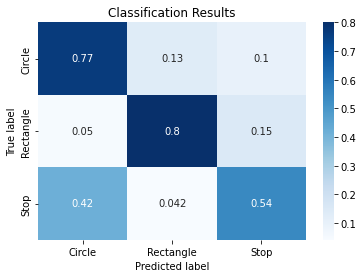

In [181]:
cm = metrics.confusion_matrix(df_found["class"], df_found["classification"])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure()

heatmap = sns.heatmap(cm, annot=True, cmap="Blues")

heatmap.xaxis.set_ticklabels(['Circle','Rectangle', 'Stop'])
heatmap.yaxis.set_ticklabels(['Circle','Rectangle', 'Stop'])

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Classification Results')

plt.show()    

### Extra: Save Results Table on a Webpage

In [182]:
from IPython.core.display import HTML

def append_images(row):
    return "output/concatenated/" + row.filename

def append_result(row):
    return row.classification is row["class"]

def path_to_image_html(path):
    return '<a target="_blank" href="' + path + '"><img src="'+ path + '" width="100" ></a>'


df["result"] = df.apply(append_result, axis=1)
df["image"] = df.apply(append_images, axis=1)

In [183]:
df = df.sort_values(by=['class'], ascending=False)
df.to_html('results.html', escape=False, formatters=dict(image=path_to_image_html))